# 어제 오른 내 주식, 과연 내일은?

ARIMA 시계열 분석법을 배우고, 직접 주식 시세를 예측해 본다.

## 목차

- 들어가며
- 시계열 예측이란?
  - 미래를 예측하는 것..?
  - 안정적인 시계열 데이터(Stationary Series Data)
  - Example
  - Stationary 여부 체크법
- ARIMA(Auto-regressive Integrated Moving Average) 시계열 예측
  - Statinary하게 변경하기
  - ARIMA 모델이란?
  - ARIMA train & prediction
- 프로젝트 : 주식 에측에 도전해보자
- 회고
- Ref

## 들어가며

## 시계열 예측이란?

### 미래를 예측하는 것..?

대표적인 예측 시나리오
***

- 주가 변화 데이터 -> 주가 변동 예측
- 특정 지역 기후 데이터 -> 온도 예측
- 공장 데이터 변화 이력 -> 이상 예측

시계열 데이터?
***

[![00](img/00.webp)](https://matplotlib.org/stable/gallery/text_labels_and_annotations/date_index_formatter.html?highlight=series)

위 시나리오에서 사용되는 데이터의 형태

- index가 날짜 데이터임
- 일정한 간격으로 있지 않아도 됨(1월, 2월, 4월)

미래 예측을 하기 위해서는?
***

- **미래 예측은 불가능** 함!
- 시도하기 위한 최소한의 조건
  - 과거 일정한 패턴 발견
  - 미래에도 동일하게 반복될 것임

위 조건을 한 단어로 안정적(Stationary)이다 라고 할 수 있음

- 데이터의 통계적 특성이 변하지 않는다!
- `외부적 변수`에 의해 Stationary 한 특성이 훼손될 수 있음

Stationary 한 데이터가 있는가?
***

[![01](img/01.gif)](https://tenor.com/view/ekg-heart-rate-gif-13302969)

- 심장박동(X)

### 안정적인 시계열 데이터(Stationary Series Data)

시간과 관계없이 일정해야하는 통계적 특성
***

- 평균
  - ![02](img/02.webp)
- 분산(covariance) - 각 집단간 얼마나 다른가?
  - ![03](img/03.png)
- 공분산(autocovariance)
  - ![04](img/04.webp)

### Example

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

데이터 다운받기
***

In [4]:
# https://medium.com/analytics-vidhya/fetch-data-from-kaggle-with-python-9154a4c610e3

from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
api = KaggleApi()
api.authenticate()

In [5]:
# 이 유저의 데이터 리스트 확인
data_names = api.dataset_list(user='paulbrabban')
data_names

[paulbrabban/daily-minimum-temperatures-in-melbourne]

In [6]:
# 유저의 데이터 다운
file_path = str(data_names[0]).split('/')[1]
if os.path.exists('data/' + str(data_names[0]) + '.zip'):
  api.dataset_download_files(str(data_names[0]), 'data')
  with ZipFile(f'data/{file_path}.zip') as zf:
    zf.extractall(f'data/') 

데이터 전처리
***

In [7]:
df = pd.read_csv(f'data/{file_path[:-7]}.csv', index_col='Date', parse_dates=True)

In [8]:
ts1 = df['Daily minimum temperatures in Melbourne, Australia, 1981-1990']

# 데이터 문자에서 수치로
# 숫자화, 오류 무시
ts1 = pd.to_numeric(ts1, errors = 'coerce')

# 결측치 확인
ts1[ts1.isna()]

# 결측치 보간
ts1 = ts1.interpolate(method='time')

In [9]:
indexes = ts1.index[1:] - ts1.index[:-1]
print(indexes.unique())

missings = indexes.get_loc('2 days').nonzero()
print(missings)

for missing in missings[0]:
  print(ts1[missing:(missing + 2)])

TimedeltaIndex(['1 days', '2 days'], dtype='timedelta64[ns]', name='Date', freq=None)
(array([1459, 2919]),)
Date
1984-12-30    16.4
1985-01-01    13.3
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64
Date
1988-12-30    14.1
1989-01-01    14.3
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64


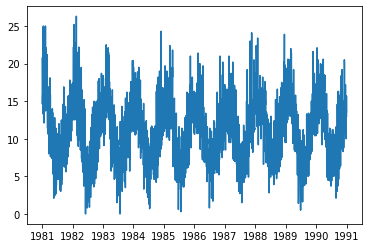

In [10]:
from matplotlib.pylab import rcParams

# figure size 기본값 변경
rcParams['figure.figsize'] = 13, 6
plt.plot(ts1)


직관적으로 평균, 분산, 공분산의 패턴이 보임

명확하게 확인하는 법!
***

- 구간의 평균(rolling mean, `이동평균선`(이평선))
- 구간의 표준편차(rolling std, `이동표준편차`)
  - 표준편차 == 분산 ** 0.5

In [11]:
def plot_rolling_statistics(timeseries, window=12):
  
  rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
  rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

  # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
  plt.plot(timeseries, color='b',label='Original')    
  plt.plot(rolmean, color='r', label='Rolling Mean')
  plt.plot(rolstd, color='k', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

In [46]:
ts1.describe()

count    3650.000000
mean       11.179342
std         4.068131
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

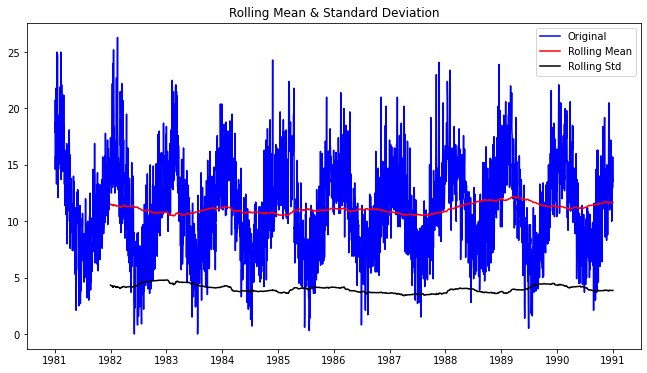

In [44]:
# window가 좁을수록 요동치며 넓을수록 과거값에 얽힌다
plot_rolling_statistics(ts1, window=365)

다른 데이터와 비교하여 생각해보자!
***

In [13]:
# 이 유저의 데이터 리스트 확인
data_names = api.dataset_list(user='andreazzini')
data_names

[andreazzini/international-airline-passengers]

In [14]:
# 유저의 데이터 다운
file_path = str(data_names[0]).split('/')[1]
if os.path.exists('data/' + str(data_names[0]) + '.zip'):
  api.dataset_download_files(str(data_names[0]), 'data')
  with ZipFile(f'data/{file_path}.zip') as zf:
    zf.extractall(f'data/') 

In [15]:
df = pd.read_csv(f'data/{file_path}.csv', index_col='Month', parse_dates=True)

In [16]:
col_name = df.columns[0]
ts2 = df[col_name]

In [17]:
indexes = ts2.index[1:] - ts2.index[:-1]
print(indexes.unique())

TimedeltaIndex(['31 days', '28 days', '30 days', '29 days'], dtype='timedelta64[ns]', name='Month', freq=None)


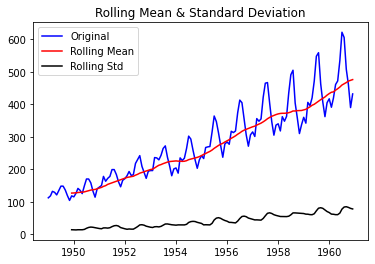

In [18]:
plot_rolling_statistics(ts2, window=12)

시각적으로 평균과 분산이 증가함을 알 수 있음!

**Stationary 하지 않음**

하지만 규칙이 보임..

### Stationary 여부 체크법

귀무가설? 대립가설? p-value?
***

[![05](img/05.png)](https://digital-play.tistory.com/78)

주어진 시게열 데이터가 안정적이지 않다는 `귀무가설`

vs

이 시계열 데이터가 안정적이다는 `대립가설`

[![06](img/06.png)](https://angeloyeo.github.io/2020/03/29/p_value.html)

ADF Test(Augmented Dickey-Fuller Test)
***

[![07](img/07.png)](https://aliencoder.tistory.com/10)

- yt : 현재
- c : 시계열 데이터의 level
- b : 시계열 데이터의 추세(trend)
- a : 단위근이 가질 확률(1 == 정성성을 띄지 않는다)
- e : 난수(Random Work)

In [19]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(time_series):
  # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
  df_test = adfuller(time_series, autolag='AIC')  
  
  # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
  print('Results of Dickey-Fuller Test:')
  df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in df_test[4].items():
    df_output['Critical Value (%s)' % key] = value
  print(df_output)
  
print('슝=3')

슝=3


In [20]:
# p 값을 근거(p < 0.05)로 대립가설이 채택(안정적 임)
# 검정통계량(Test Statistic)이 critical value를 넘지 않음(안정적 임)
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.440522
p-value                           0.000251
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


In [21]:
# p 값을 근거(p > 0.05)로 귀무가설이 채택(안정적이지 않음)
# 검정통계량(Test Statistic)이 critical value를 넘어버림(안정적이지 않음)
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


## ARIMA(Auto-regressive Integrated Moving Average) 시계열 예측

### Statinary하게 변경하기

1. 기존의 데이터 가공/변형
2. 시계열 분해(Time Series Decomposition)

가공하는 법
***

로그함수 변환
***

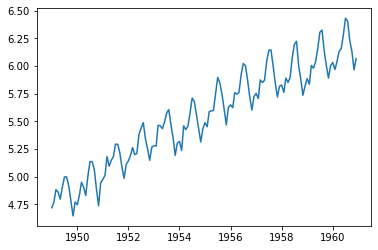

In [22]:
ts_log = np.log(ts2)
plt.plot(ts_log)

In [23]:
# 값이 절반 이상 줄어 들었음
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


추세(Trend) 상쇄하기
***

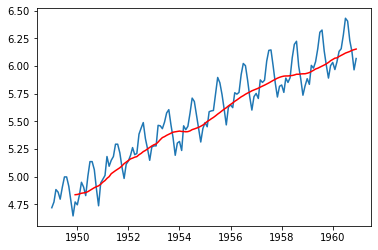

In [24]:
moving_avg = ts_log.rolling(window = 12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='r')

In [25]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60, dtype: float64

In [26]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60, dtype: float64

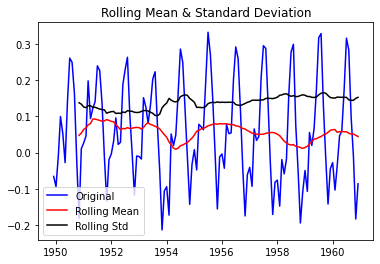

In [27]:
plot_rolling_statistics(ts_log_moving_avg)

In [28]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


왜 윈도우가 12인가? 6이면 안되는가?
***

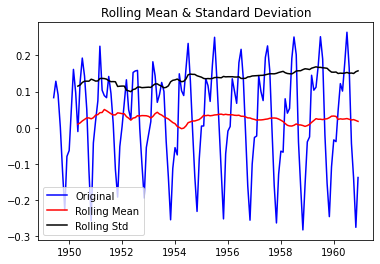

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


In [29]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

plot_rolling_statistics(ts_log_moving_avg_6)

augmented_dickey_fuller_test(ts_log_moving_avg_6)

차분(계절성(Seasonality) 상쇄
***

나의 위치와 바로 뒤에 있는 요소를 뺀 변화률을 확인함

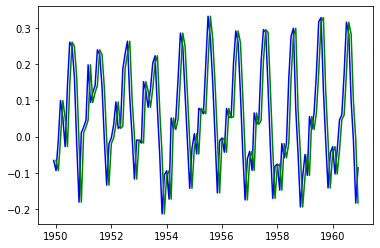

In [30]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

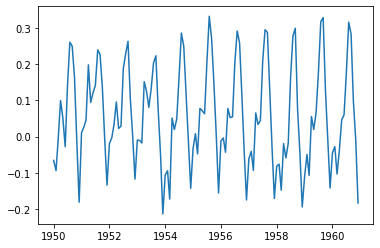

In [31]:
plt.plot(ts_log_moving_avg_shift)

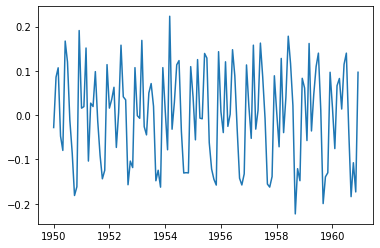

In [32]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

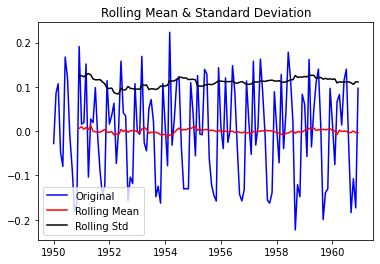

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [33]:
plot_rolling_statistics(ts_log_moving_avg_diff)
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

시계열 분해(Time series decomposition)
***

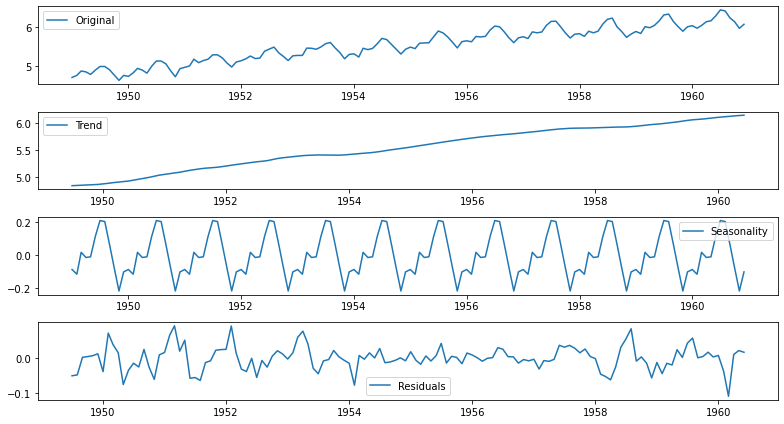

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log) # 이전의 작업을 한번에 실행해줌

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### ARIMA 모델이란?

ARIMA(Autoregressive Integrated Moving Average)

AR + I + MA

AR(자기회귀, Autoregressive)
***

[![08](img/08.png)](https://otexts.com/fppkr/AR.html)

[![09](img/09.png)](https://otexts.com/fppkr/AR.html)

과거값을 토대로 미래를 예측함

- 장기적으로 일정하게 움직일 것이라고 가정함

MA(이동평균, Moving Average)
***

[![10](img/10.png)](https://otexts.com/fppkr/MA.html)

[![11](img/11.png)](https://otexts.com/fppkr/MA.html)

과거 에러를 토대로 미래를 예측함

- 이전과 비교해서 지금 어떻게 변하고 있는지 알아내고,
- 그에 따른 Trend를 알아내게 됩니다.

I(차분 누적, Integration)
***

계절성을 줄이는 방법

ARIMA 모델의 모수 p, q, d
***

일반적으로 `p + q < 2`거나 `p * q = 0` 인 값을 사용함

어떻게 p, q, d를 설정하는가?

ACF(Autocorrelation Function) & PACF(Partial ACF)

ACF

- 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수

PACF

- `다른 관측치를 배제`하고 두 시차의 관측치 간 관련성 측정하는 함수

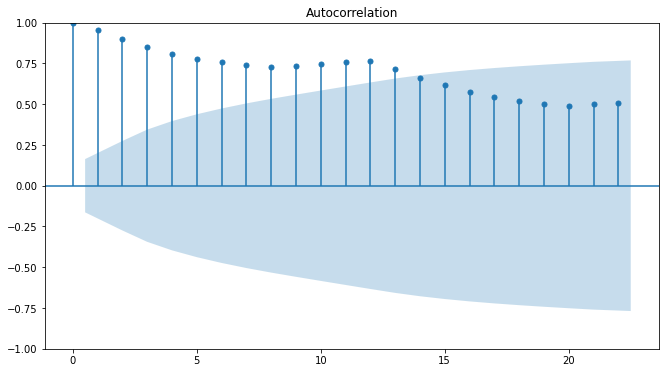

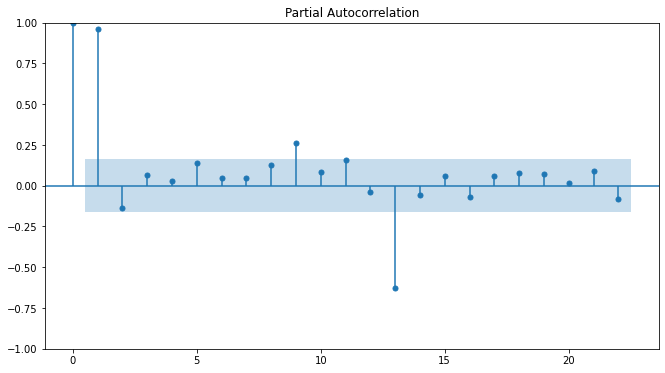

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


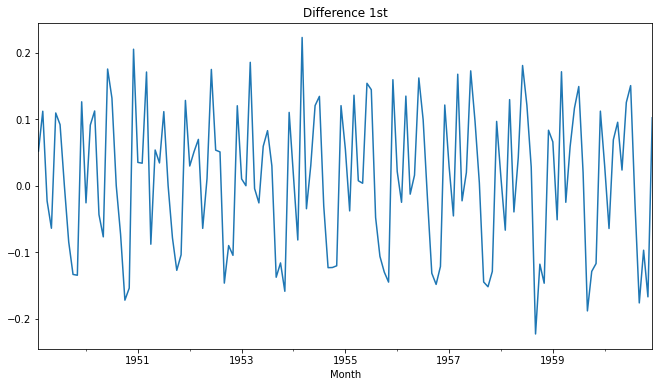

In [36]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


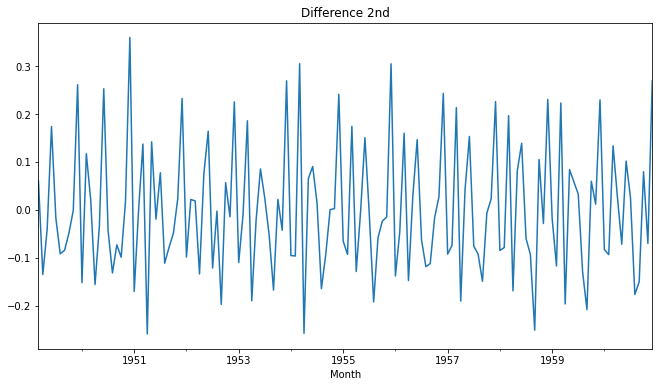

In [37]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

학습 데이터 분리
***

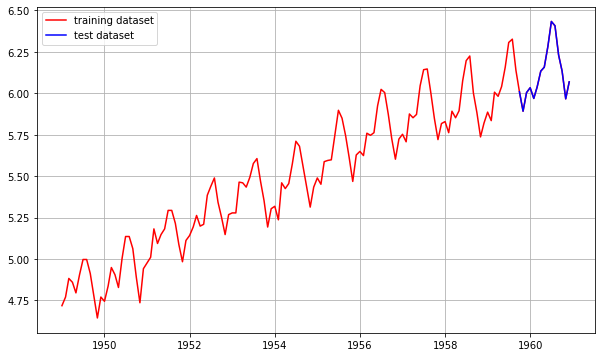

In [38]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [39]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60, dtype: float64
(129,)
(15,)


### ARIMA train & prediction

In [40]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 1)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                                                             SARIMAX Results                                                              
Dep. Variable:     International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60   No. Observations:                  129
Model:                                                                            ARIMA(14, 1, 1)   Log Likelihood                 219.591
Date:                                                                            Fri, 22 Jul 2022   AIC                           -407.182
Time:                                                                                    16:18:02   BIC                           -361.550
Sample:                                                                                01-01-1949   HQIC                          -388.642
                                                                                     - 09-01-1959                                         
Covariance Type:           

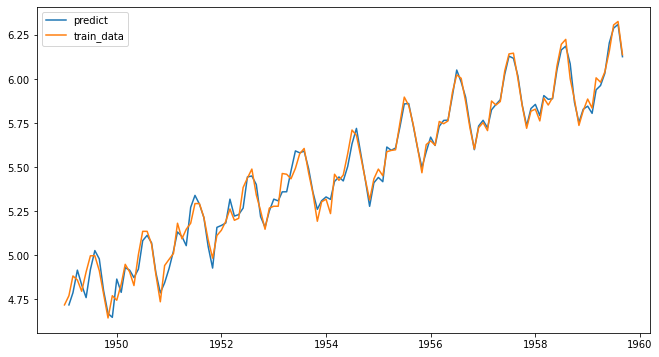

In [41]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

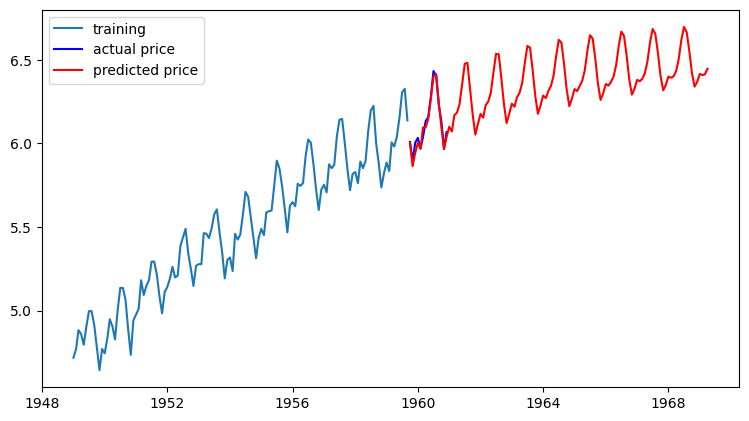

In [58]:
model = ARIMA(train_data, order=(14, 1, 1))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data) + 100, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  175.9663426606973
MAE:  10.75320768881503
RMSE:  13.265230592066514
MAPE: 2.38%


## 프로젝트 : 주식 에측에 도전해보자

## 회고

배우고 궁금한 것
***

어려웠는 것
***

시도한 것
***

실패한 것과 그 이유
***

## Ref

|날짜|제목(링크)|내용|
|:-:|:--------:|:--:|
|?|[matplotlib series](https://matplotlib.org/stable/gallery/text_labels_and_annotations/date_index_formatter.html?highlight=series)|tick formatter 변경|
|?|[heart rate](https://tenor.com/view/ekg-heart-rate-gif-13302969)|심장박동 gif|
|15.12.16|[R의 시계열 모델링에 대한 완전한 자습서](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)|평균, 분산, 공분산 사진 인용|
|20.10.18|[통계적 가설 검증 방법](https://digital-play.tistory.com/78)|귀무가설, 대립가설, p-value 설명|
|20.03.29|[p-value의 의미](https://angeloyeo.github.io/2020/03/29/p_value.html)|p-value가 의미가 있는가?|
|21.12.08|[ADF(Augmented Dickey-Fuller Test를 이용한 정상성 확인](https://aliencoder.tistory.com/10)|DF와 ADF 설명|
|?|[자기회귀 모델](https://otexts.com/fppkr/AR.html)|AR 설명|
|?|[이동 평균 모델](https://otexts.com/fppkr/MA.html)|MA 설명|